### NLP Project: Reviews Classifier

In this project, I aim to build a model to classify Amazon reviews into classes. In particular deciding if reviews are Positive or Negative.

Data is provided as JSON, need JSON package to read data in. 

In [2]:
import json
import numpy as np
import pickle
import matplotlib.pyplot as plt
from reviewer import Review
from data_optimiser import DataOptimizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import svm
from sklearn import linear_model
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

The data is very large and contains more than 100,000 reviews, for performance, I'm going to only use 10000 reviews. Furthermore, I'll distribute the sentiments equally, ie each sentiment label will appear roughly an equal number of times in the data.

In [5]:
data = []
num_datapoints = 10000
count = 0
with open('./Data/Video_Games_5.json') as f:
    for line in f:
        if count <= num_datapoints:
            count += 1 
            json_line = json.loads(line)
            data.append(Review(json_line['reviewText'],json_line['overall']))
        else:
            break 

Split Data: 70% Train, 30% testing:

In [6]:
train_data, test_data = train_test_split(data, test_size=0.3, train_size=0.7, random_state=10)
train_reviews, train_sentiments = DataOptimizer(train_data).get_reviews_ratings()
test_reviews, test_sentiments = DataOptimizer(test_data).get_reviews_ratings()
print(len(train_reviews))
print(len(test_reviews))

2562
1124


I'll be using a "Bag of Words" method to extract the features from the reviews. Note that: CountVectorizer/TfidfVectorizer can fit and transform, the ouput is stored as a dense numpy array. Can use .toarray() to visualise if needed.

In [12]:
feature_extractor = TfidfVectorizer()
train_X = feature_extractor.fit_transform(train_reviews)
test_X = feature_extractor.transform(test_reviews)

##### Fitting Model:

Using GridSearch to optimize model hyperparameters.

In [5]:
parameters = {'kernel': ('linear', 'rbf', 'sigmoid'), 'C' : (1, 2, 4, 10)}
support_vector_model = svm.SVC()
tuned_model = GridSearchCV(support_vector_model, parameters, cv=5)
tuned_model.fit(train_X, train_sentiments)
tuned_model.best_params_

{'C': 1, 'kernel': 'rbf'}

In [6]:
tuned_model.score(test_X, test_sentiments)

0.7508896797153025

In [7]:
print(f1_score(test_sentiments, tuned_model.predict(test_X), average=None, labels=['Positive', 'Negative']))

[0.74591652 0.7556719 ]


Save Model:

In [8]:
with open('./Models/SVM_Games_Reviews.pkl', 'wb') as f:
    pickle.dump(tuned_model, f)

Save Vectorizer:

In [9]:
with open('./Models/SVM_Games_Vectorzier.pkl', 'wb') as f:
    pickle.dump(feature_extractor, f)

Load Model and Vectorizer:

In [3]:
with open('./Models/SVM_Games_Reviews.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

In [4]:
with open('./Models/SVM_Games_Vectorzier.pkl', 'rb') as f:
    vectorizer = pickle.load(f)

In [19]:
example_pos = "This is a great game"
example_neg = 'Never seen such a terrible game before'
examples = [example_pos, example_neg]
vec_example = vectorizer.transform(examples)
loaded_model.predict(vec_example)

array(['Positive', 'Negative'], dtype='<U8')

Let's plot the confusion matrix to get an idea of how the model is performing:

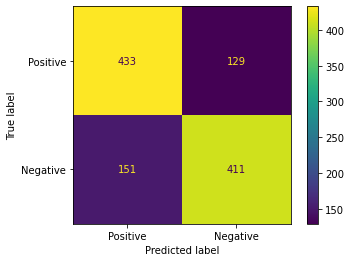

In [16]:
confusion_mat = confusion_matrix(test_sentiments, loaded_model.predict(test_X))
confusion_mat_fig = ConfusionMatrixDisplay(confusion_mat, display_labels=['Positive', 'Negative'])
confusion_mat_fig.plot()
plt.show()
